In [1]:

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from numpy import mean

c:\Users\pzazo\anaconda3\envs\tf-gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pzazo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pzazo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocess dataset

In [2]:
regex_pattern = re.compile(r'[^a-zA-Z0-9\s]')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = regex_pattern.sub('', text)
    text = text.lower()
    tokens = word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return filtered_tokens

df = pd.read_csv('bigdata2023classification/train.csv', delimiter=',')
df['Content'] = df['Content'].apply(preprocess_text)

# Fit Tokenizer to learn the vocabulary of the dataset

In [3]:
NUM_WORDS = 10000   # max number of words in the vocabulary

# Tokenize the text and convert it to sequences of integers
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Content'])
sequences = tokenizer.texts_to_sequences(df['Content'])

# Data Generator

In [4]:
def data_generator(data, labels, batch_size, maxlen, tokenizer):
    num_samples = len(data)
        
    while True:
        for offset in range(0, num_samples, batch_size):
            # Get the current batch data and labels
            batch_data = data[offset:offset+batch_size]
            batch_labels = labels[offset:offset+batch_size]
            
            # Tokenize and pad the batch data
            batch_sequences = tokenizer.texts_to_sequences(batch_data)
            batch_padded_sequences = pad_sequences(batch_sequences, maxlen=maxlen, padding='post', truncating='post')
            
            yield np.array(batch_padded_sequences), np.array(batch_labels)


# Tokenization

Average Sequence Length: 249
Maximum Sequence Length: 8400


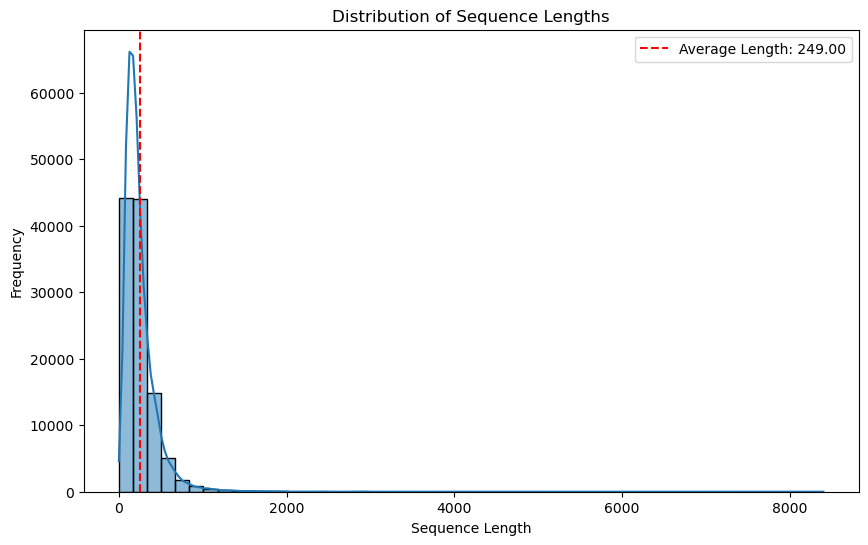

In [5]:
sequence_lengths = [len(x) for x in sequences]

max_seq_length = max(sequence_lengths)
average_length = int(mean(sequence_lengths))

print(f"Average Sequence Length: {average_length}")
print(f"Maximum Sequence Length: {max_seq_length}")

sequence_len = average_length # Average length of the sequences as sequence length for padding and truncating the sequences 

plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axvline(x=average_length, color='r', linestyle='--', label=f'Average Length: {average_length:.2f}')
plt.legend()
plt.show()

# Label Encoding

In [6]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df['Label'])
X_train, X_test, y_train, y_test = train_test_split(df['Content'], integer_encoded, test_size=0.2, random_state=42, stratify=integer_encoded)

# Model Structure

In [7]:
EMBEDDING_DIM = 300 
LSTM_UNITS = 128
DROPOUT = 0.2
BATCH_SIZE = 64

def create_model(input_length, num_classes):
    model = Sequential([
        Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=input_length),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
        Dropout(DROPOUT),
        LSTM(LSTM_UNITS, return_sequences=False),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model(sequence_len, len(np.unique(y_train)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 249, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 249, 256)          439296    
_________________________________________________________________
dropout (Dropout)            (None, 249, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 3,636,932
Trainable params: 3,636,932
Non-trainable params: 0
_________________________________________________________________


# Model Train

In [8]:
train_generator = data_generator(X_train, y_train, BATCH_SIZE, sequence_len, tokenizer)
# ensuring all samples are used for training
steps_per_epoch = np.ceil(len(X_train) / BATCH_SIZE).astype(int)
validation_generator = data_generator(X_test, y_test, BATCH_SIZE, sequence_len, tokenizer)
# ensuring all samples are used for validation
num_test_steps = np.ceil(len(X_test) / BATCH_SIZE).astype(int)

history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=num_test_steps,
                    epochs=10)


Epoch 1/10
1398/1398 [==============================] - 175s 115ms/step - loss: 0.6608 - accuracy: 0.7370 - val_loss: 0.2289 - val_accuracy: 0.9299
Epoch 2/10
1398/1398 [==============================] - 154s 110ms/step - loss: 0.1748 - accuracy: 0.9436 - val_loss: 0.1546 - val_accuracy: 0.9496
Epoch 3/10
1398/1398 [==============================] - 154s 110ms/step - loss: 0.1164 - accuracy: 0.9619 - val_loss: 0.1445 - val_accuracy: 0.9559
Epoch 4/10
1398/1398 [==============================] - 153s 110ms/step - loss: 0.0920 - accuracy: 0.9694 - val_loss: 0.1415 - val_accuracy: 0.9564
Epoch 5/10
1398/1398 [==============================] - 155s 111ms/step - loss: 0.0735 - accuracy: 0.9753 - val_loss: 0.1324 - val_accuracy: 0.9597
Epoch 6/10
1398/1398 [==============================] - 195s 140ms/step - loss: 0.0603 - accuracy: 0.9795 - val_loss: 0.1426 - val_accuracy: 0.9588
Epoch 7/10
1398/1398 [==============================] - 157s 112ms/step - loss: 0.0500 - accuracy: 0.9829 - val_

# Model Evaluation

In [9]:

# re initialize generator to get all samples in test set
predict_generator = data_generator(X_test, y_test, BATCH_SIZE, sequence_len, tokenizer)
# # ensuring all samples are used for prediction
predict_steps = np.ceil(len(X_test) / BATCH_SIZE).astype(int)

# Predict using the predict generator
predictions = model.predict(predict_generator, steps=predict_steps)
# Get the predicted class label
predicted_labels = predictions.argmax(axis=1)
print(classification_report(y_test, predicted_labels, target_names=label_encoder.classes_))

               precision    recall  f1-score   support

     Business       0.92      0.93      0.93      4967
Entertainment       0.98      0.98      0.98      8967
       Health       0.97      0.95      0.96      2404
   Technology       0.95      0.94      0.94      6021

     accuracy                           0.96     22359
    macro avg       0.95      0.95      0.95     22359
 weighted avg       0.96      0.96      0.96     22359



# Confusion Matrix

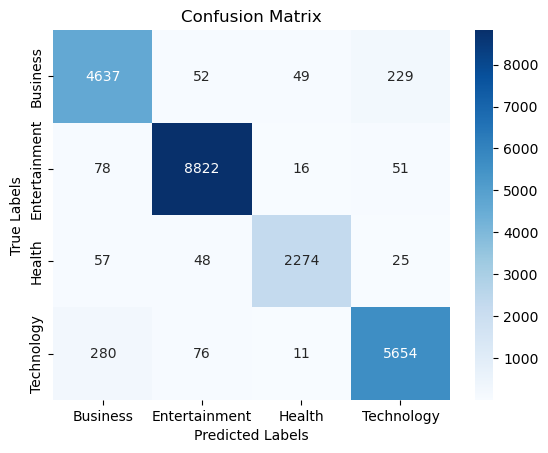

In [10]:
conf_mat = confusion_matrix(y_test, predicted_labels)

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Training and Validation Accuracy/Loss over time

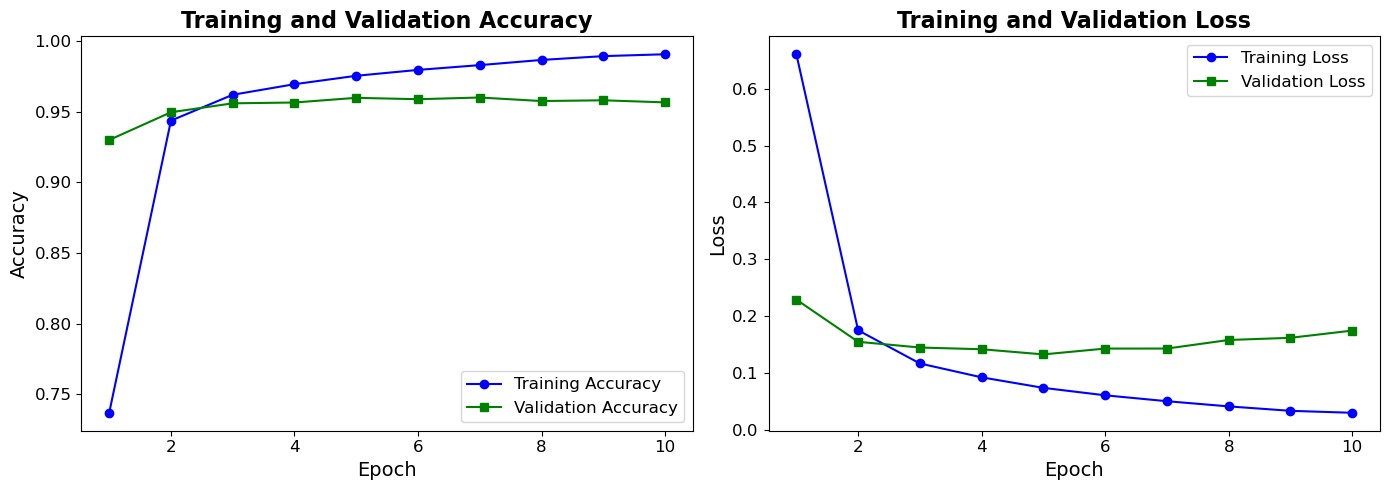

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'gs-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Plot training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'gs-', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


# Predicting the test dataset

In [ ]:
test_df = pd.read_csv('bigdata2023classification/test.csv', delimiter=',')
test_df['Content'] = test_df['Content'].apply(preprocess_text)

# Tokenize test data
test_sequences = tokenizer.texts_to_sequences(test_df['Content'])

# Pad sequences
test_padded = pad_sequences(test_sequences, maxlen=sequence_len, padding='post', truncating='post')

# Predict using the model
test_predictions = model.predict(test_padded)
# Get the predicted class label
test_predicted_labels = test_predictions.argmax(axis=1)
predicted_label_names = label_encoder.inverse_transform(predicted_labels)

